In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
import glob
import os
import random
import time

In [59]:
from PIL import Image
import cv2 as cv

In [60]:
from sklearn.model_selection import train_test_split

In [61]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
    in_colab = True
except:
    in_colab = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
if in_colab:
    epidural_folder = '/content/drive/MyDrive/Zeta_Surgical_Segmentation/segmentation_dataset/epidural'
else:
     epidural_folder = "./segmentation_dataset/epidural/"   

In [63]:
epidural_folder_mask = epidural_folder + '_mask/'

## Training Image Segmentation for Epidural

In [64]:
images = sorted(glob.glob(os.path.join(epidural_folder, "*")))
masks = sorted(glob.glob(os.path.join(epidural_folder_mask, "*")))
print(f"Augmented images:  {len(images)} - Augmented masks: {len(masks)}")

Augmented images:  500 - Augmented masks: 500


In [65]:
df = pd.DataFrame({'images':images, 'masks':masks})
img_train, img_test, mask_train, mask_test = train_test_split(df['images'], df['masks'], test_size=0.15, random_state=7)
img_val, img_test, mask_val, mask_test = train_test_split(img_test, mask_test, test_size=0.3, random_state=7)
print(len(img_train), len(img_val), len(img_test))

425 52 23


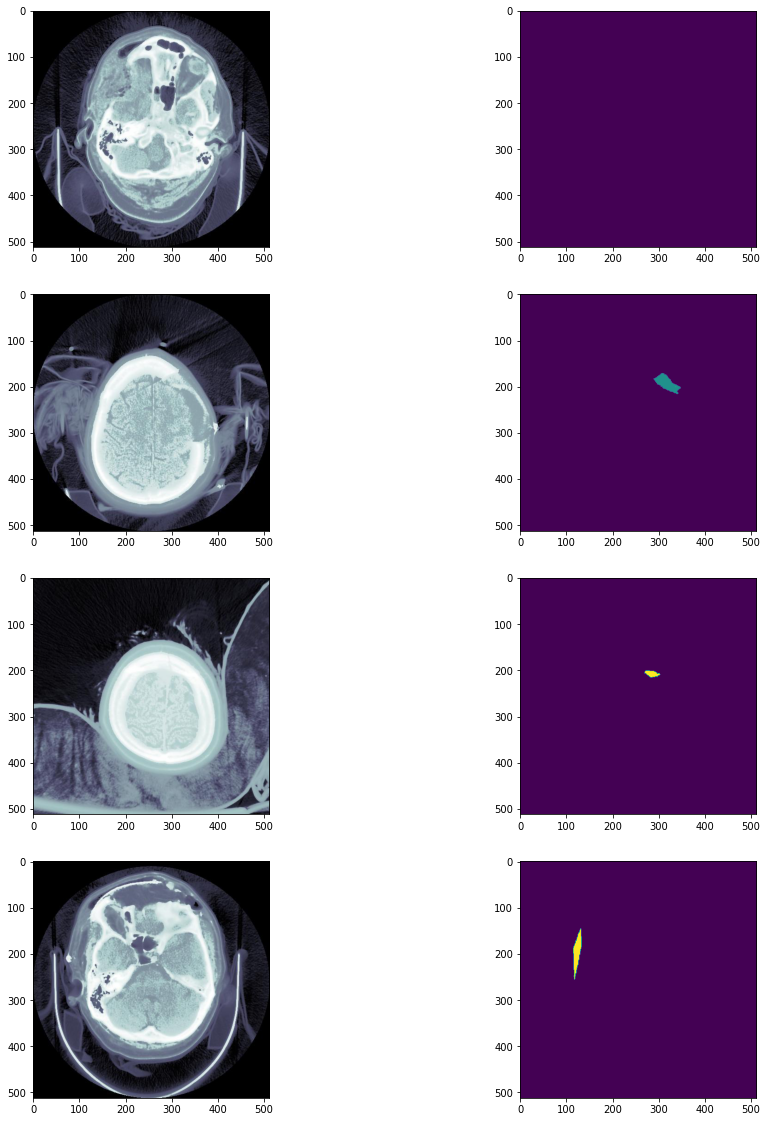

In [9]:
def visualize_img_mask(img_train, mask_train, k = 3):
    N = img_train.shape[0]
    fig, ax = plt.subplots(k, 2, figsize=(8*2, 5*k))
    for i,l in enumerate(random.sample(range(N), k)):
        img = img_train.iloc[l]
        mask = mask_train.iloc[l]
        ax[i,0].imshow(Image.open(img))
        # ax[i,1].imshow(Image.open(mask))
        ax[i,1].imshow(cv.imread(mask, cv.IMREAD_GRAYSCALE))
        
visualize_img_mask(img_train, mask_train, k=4)

In [66]:
from skimage import io

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler
import tensorflow.keras.backend as K

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.applications import VGG19

from warnings import filterwarnings
filterwarnings('ignore')

import random

np.random.seed(7)
tf.random.set_seed(7)

In [67]:
def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        
        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true, y_pred)

        # Apply the weights
        
        weight_vector = y_true * one_weight + (1. - y_true) * zero_weight
        weighted_b_ce = weight_vector * b_ce
        
        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy
model_loss = create_weighted_binary_crossentropy(zero_weight=0.1, one_weight=0.9)

def weighted_categorical_crossentropy(weights):
    # weights = [0.9,0.05,0.04,0.01]
    def wcce(y_true, y_pred):
        Kweights = K.constant(weights)
        # if not K.is_tensor(y_pred): y_pred = K.constant(y_pred)
        y_true = K.cast(y_true, y_pred.dtype)
        return K.categorical_crossentropy(y_true, y_pred) * K.sum(y_true * Kweights, axis=-1)
    return wcce
model_loss = weighted_categorical_crossentropy([0.01, 0.99])

In [72]:
n_classes = 2
H = 512    
W = H*6//4   # to keep the H:W ratio equal to 4000:6000 <- the original ratio

def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_vgg19_unet(input_shape):
    """ Input """
    inputs = Input(input_shape)

    """ Pre-trained VGG19 Model """
    vgg19 = VGG19(include_top=False, weights="imagenet", input_tensor=inputs)

    """ Encoder """
    s1 = vgg19.get_layer("block1_conv2").output         
    s2 = vgg19.get_layer("block2_conv2").output         
    s3 = vgg19.get_layer("block3_conv4").output         
    s4 = vgg19.get_layer("block4_conv4").output         

    """ Bridge """
    b1 = vgg19.get_layer("block5_conv4").output         

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)                     
    d2 = decoder_block(d1, s3, 256)                     
    d3 = decoder_block(d2, s2, 128)                    
    d4 = decoder_block(d3, s1, 64)                      

    """ Output """
    outputs = Conv2D(n_classes, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="VGG19_U-Net")
    model.compile(loss=model_loss, optimizer='adam', metrics=['accuracy'])
    return model

model = build_vgg19_unet((H,W,3))
# Retrieve the config
config = model.get_config()

# At loading time, register the custom objects with a `custom_object_scope`:
## https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object
custom_objects = {"model_loss": model_loss}
with keras.utils.custom_object_scope(custom_objects):
    model = keras.Model.from_config(config)
model.compile(loss=model_loss, optimizer='adam', metrics=['accuracy'])

In [73]:
## Dataset Pipeline used for training the model

def read_image(x):
    x = cv.imread(x, cv.IMREAD_COLOR)
    x = cv.resize(x, (W, H))
    x = x/255.0
    x = x.astype(np.float32)
    return x


def read_mask(x):
    x = cv.imread(x, cv.IMREAD_GRAYSCALE)
    x = cv.resize(x, (W, H))
    x = x.astype(np.int32)
    return x


def tf_dataset(x,y, batch=4):
    dataset = tf.data.Dataset.from_tensor_slices((x,y))
    dataset = dataset.shuffle(buffer_size=500)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    dataset = dataset.prefetch(2)
    return dataset
    

def preprocess(x,y):
    def f(x,y):
        x = x.decode()
        y = y.decode()
        image = read_image(x)
        mask = read_mask(y)
        return image, mask
    
    image, mask = tf.numpy_function(f,[x,y],[tf.float32, tf.int32])
    mask = tf.one_hot(mask, n_classes, dtype=tf.int32)
    image.set_shape([H, W, 3])    # In the Images, number of channels = 3. 
    mask.set_shape([H, W, n_classes])    # In the Masks, number of channels = number of classes. 
    return image, mask

In [74]:
segmentation_path = '/content/drive/MyDrive/Zeta_Surgical_Segmentation/'
epidural_model_segmentation = segmentation_path + "epidural_model_segmentation.h5"
checkpointer = [
    ModelCheckpoint(filepath= epidural_model_segmentation, monitor='val_loss',verbose=2,save_best_only=True, save_freq='epoch'),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.1, verbose=2, min_lr=1e-6),
    EarlyStopping(monitor='val_loss', patience=3, verbose=2, min_delta=1e-4)
]

batch_size = 4
train_dataset = tf_dataset(img_train, mask_train, batch=batch_size)
val_dataset = tf_dataset(img_val, mask_val, batch=batch_size)

train_steps = len(img_train)//batch_size
val_steps = len(img_val)//batch_size

In [ ]:
num_epochs = 1
start_time = time.time()

history = model.fit(train_dataset, steps_per_epoch=train_steps, validation_data=val_dataset, validation_steps=val_steps, epochs=num_epochs, callbacks=checkpointer)
end_time = time.time()
print(f"Time-taken for training: {(end_time-start_time)/60 : .3f} min")
print(f"approx. train-time for each epoch: {(end_time-start_time)/(60*num_epochs) : .3f}")

 47/106 [============>.................] - ETA: 4:39 - loss: 0.0092 - accuracy: 0.7356

Plots for Loss and Accuracy of training:


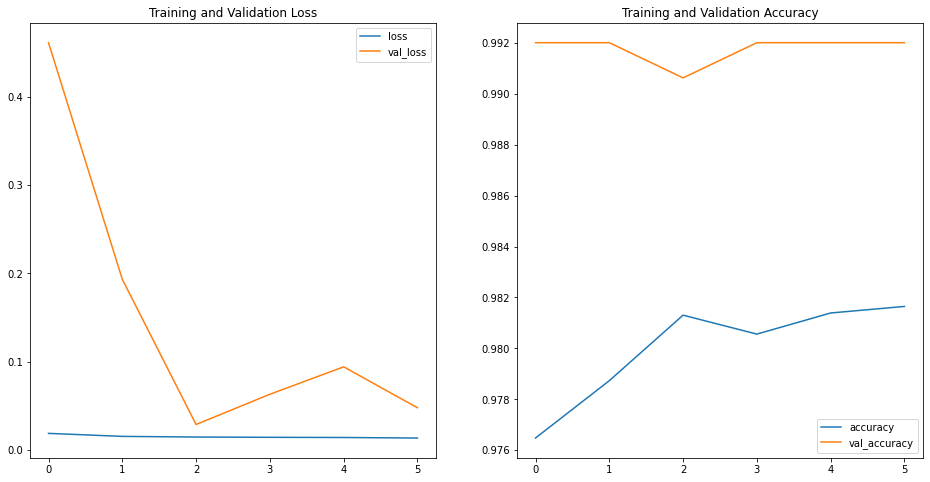

In [49]:
def plot_loss_acc(history):
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    ax[0].plot(history.history['loss'], label='loss')
    ax[0].plot(history.history['val_loss'], label='val_loss')
    ax[0].legend()
    ax[0].set_title('Training and Validation Loss')
    ax[1].plot(history.history['accuracy'], label='accuracy')
    ax[1].plot(history.history['val_accuracy'], label='val_accuracy')
    ax[1].legend()
    ax[1].set_title('Training and Validation Accuracy')
    print('Plots for Loss and Accuracy of training:')
    
plot_loss_acc(history)

In [51]:
# model_loaded = tf.keras.models.load_model('./model.h5')
model_loaded = tf.keras.models.load_model(epidural_model_segmentation)

ValueError: ignored

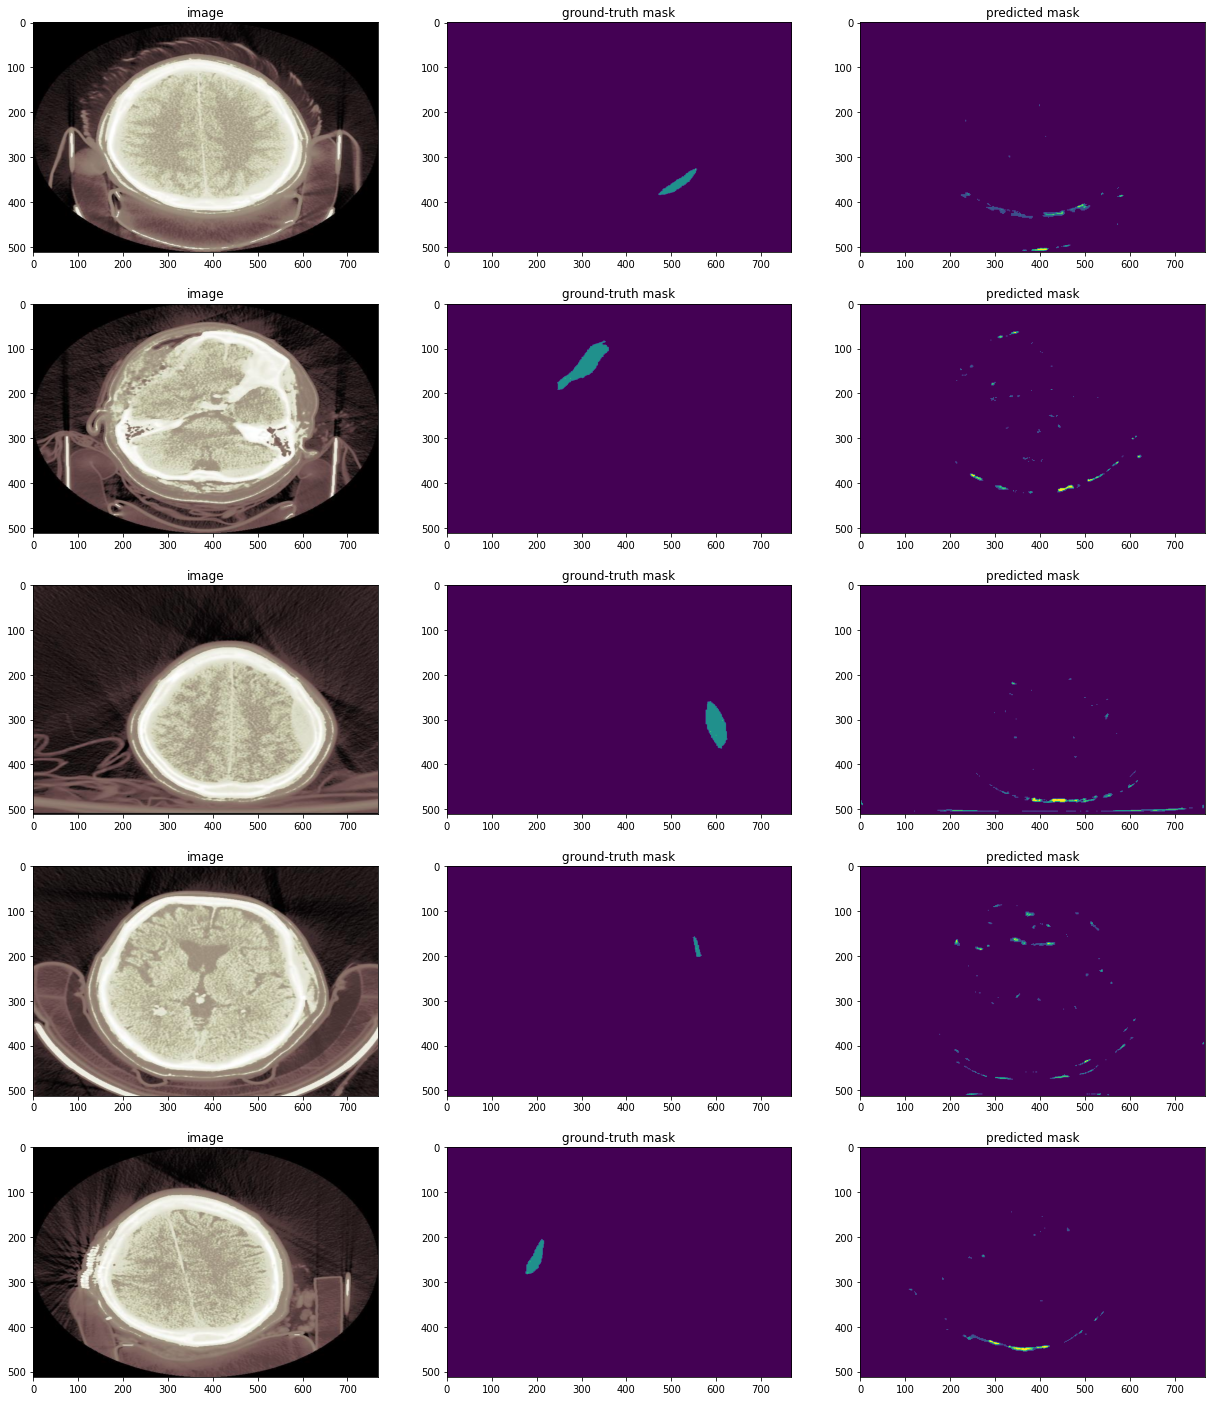

In [57]:
def visualize_predictions(img_test, mask_test, k = 3):
    N = img_test.shape[0]
    fig, ax = plt.subplots(k, 3, figsize=(7*3, 5*k))
    for i,l in enumerate(random.sample(range(N), k)):
        x = read_image(img_test.iloc[l])
        y = read_mask(mask_test.iloc[l])
        p = model.predict(x[np.newaxis, ...])[0]
        p = np.argmax(p, axis=-1)
        ax[i,0].imshow(x)
        ax[i,0].set_title('image')
        ax[i,1].imshow(y)
        ax[i,1].set_title('ground-truth mask')
        ax[i,2].imshow(p)
        ax[i,2].set_title('predicted mask')
        
visualize_predictions(img_test, mask_test, k=5)

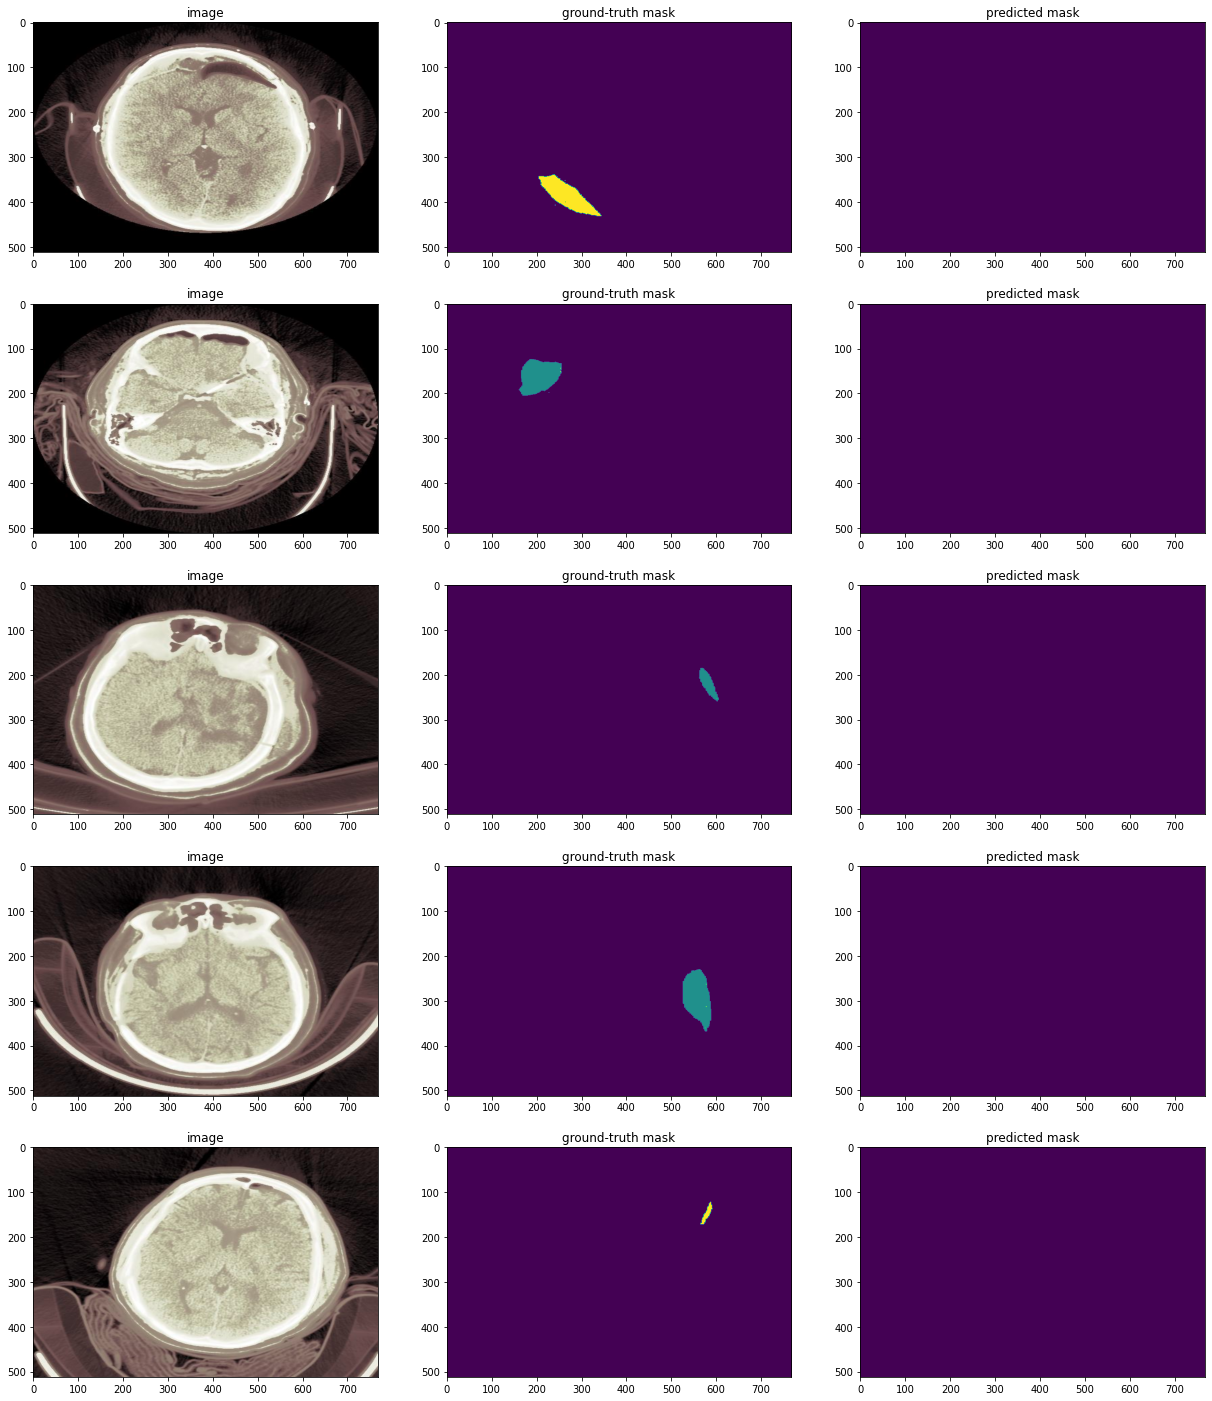

In [50]:
def visualize_predictions(img_train, mask_test, k = 3):
    N = img_test.shape[0]
    fig, ax = plt.subplots(k, 3, figsize=(7*3, 5*k))
    for i,l in enumerate(random.sample(range(N), k)):
        x = read_image(img_test.iloc[l])
        y = read_mask(mask_test.iloc[l])
        p = model.predict(x[np.newaxis, ...])[0]
        p = np.argmax(p, axis=-1)
        ax[i,0].imshow(x)
        ax[i,0].set_title('image')
        ax[i,1].imshow(y)
        ax[i,1].set_title('ground-truth mask')
        ax[i,2].imshow(p)
        ax[i,2].set_title('predicted mask')
        
visualize_predictions(img_train, mask_train, k=5)